# Install

In [1]:
!git clone https://github.com/kmrasmussen/pythia_tools.git pythia_tools
!pip install -e pythia_tools
!pip install git+https://github.com/neelnanda-io/TransformerLens.git --quiet

Cloning into 'pythia_tools'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 145 (delta 62), reused 73 (delta 25), pack-reused 34
Receiving objects: 100% (145/145), 57.73 MiB | 28.57 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Obtaining file:///content/pythia_tools
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.7

# Import

In [18]:
import torch
from pythia_tools.models import get_model, yield_models, get_n_layers, get_tokenizer
from tqdm import tqdm
from pythia_tools.visualization import hist_and_box
from transformer_lens import HookedTransformer
from pythia_tools.data import get_token_mat
import torch.nn.functional as F
from pythia_tools.nonstatic import get_many_hooks_all_layers
import matplotlib.pyplot as plt
from pythia_tools.qh import get_similarity_matrix
from pythia_tools.deembedding import decode_vocab_pmf
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tuned_lens import TunedLens
from transformers import GPTNeoXForCausalLM
import pandas as pd
import itertools
torch.set_grad_enabled(False)
import numpy as np
import pickle, sys
import psutil

In [2]:
import torch
from pythia_tools.models import get_model, yield_models, get_n_layers, get_tokenizer
from tqdm import tqdm
from pythia_tools.visualization import hist_and_box
from transformer_lens import HookedTransformer
from pythia_tools.data import get_token_mat
import torch.nn.functional as F
from pythia_tools.nonstatic import get_many_hooks_all_layers
import matplotlib.pyplot as plt
from pythia_tools.qh import get_similarity_matrix
from pythia_tools.deembedding import decode_vocab_pmf
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tuned_lens import TunedLens
from transformers import GPTNeoXForCausalLM
import pandas as pd
import itertools
from pythia_tools.utils import mem_size

# Load

In [3]:
T = get_token_mat()

torch.Size([10691, 600])


In [4]:
#TL = torch.load('/content/drive/MyDrive/thesis/data/token_mats/val_77k_600.pt')

In [3]:
TL = torch.load('/content/drive/MyDrive/thesis/data/token_mats/train_322k_600.pt')

In [4]:
mem_size(TL)

1477.5375366210938

In [ ]:
model = get_model('70m', 143, True)

Not using rev for transformerlens, something weird with rev please fix


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer


In [5]:
tokenizer = get_tokenizer()

In [4]:
bigrams_dict = torch.load('/content/drive/MyDrive/thesis/data/bigrams/bigrams_dict_77k.pt') #torch.load('/content/drive/MyDrive/thesis/data/bigrams/bigrams_dict_10k.pt')

In [5]:
bigrams_dict['sorted_bigrams'].shape

torch.Size([6859148, 2])

In [6]:
bigrams = bigrams_dict['sorted_bigrams']

In [7]:
#consequent_sets = torch.load('/content/drive/MyDrive/thesis/data/bigrams/consequent_sets_bigrams_10k.pt')

In [8]:
bigrams_considered = 30000

In [27]:
unigram_set = set(bigrams[:bigrams_considered].reshape(-1).unique().tolist())

In [26]:
len(bigrams[:bigrams_considered].reshape(-1).unique().tolist())

7421

In [10]:
# Initialize a set with 10,000 tuples. For this example, we're just making random tuples.
tuple_set = {(bigram[0].item(), bigram[1].item()) for bigram in bigrams[:bigrams_considered]}

# To check if a tuple (a, b) exists in the set
if (187, 4041) in tuple_set:
    print("The tuple exists.")
else:
    print("The tuple does not exist.")


The tuple exists.


In [11]:
def get_occurences_combi4(seqs_tensor, min_j=20):
  n = 2

  precise_occs = {}

  for i in tqdm(range(seqs_tensor.shape[0])):
    for j in range(min_j, 596): #seqs_tensor.shape[1] - n + 1):
          # Extract trigram from seqs_tensor
      seq_trigram = tuple(seqs_tensor[i, j:j+n].tolist())

      if seq_trigram in tuple_set:
              # If there's an exact match, append the location to the corresponding list in occurences
        #print((i,j))
        if seq_trigram not in precise_occs:
          precise_occs[seq_trigram] = [(i,j)]
        elif len(precise_occs[seq_trigram]) < 10000:
          precise_occs[seq_trigram].append((i,j))
  return precise_occs

In [31]:
# WARNING: This sampling of negatives is BIASED because it removes tuples that are bigram set
def get_occurences_combi_negatives(seqs_tensor, min_j=20, biased_sampling=False):
  n = 2

  precise_occs = {}


  for i in tqdm(range(seqs_tensor.shape[0])):
    for j in range(min_j, 596): #seqs_tensor.shape[1] - n + 1):
          # Extract trigram from seqs_tensor
      seq_trigram_before = tuple(seqs_tensor[i, j:j+n].tolist())
      seq_trigram_after = tuple(seqs_tensor[i, j+1:j+1+n].tolist())

      if biased_sampling:
        if seq_trigram_before in tuple_set or seq_trigram_after in tuple_set:
          continue

      locus = seq_trigram_before[1]

      if locus in unigram_set:
        item = ((i,j), seq_trigram_before, seq_trigram_after)
        if locus not in precise_occs:
          precise_occs[locus] = [item]
        elif len(precise_occs[locus]) < 5000:
          precise_occs[locus].append(item)

    vm = psutil.virtual_memory()
    # Convert bytes to GB and print available RAM
    available_ram_gb = vm.available / (1024 ** 3)
    if available_ram_gb < 3:
      print('breaking at line', i, 'because of RAM limit')
      break
  return precise_occs

In [32]:
def load_pkl(path):
  with open(path, 'rb') as file:
    # Load data from the file
    loaded_data = pickle.load(file)
  return loaded_data

In [33]:
def save_pkl(obj, path):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

In [17]:
precise_occsL = get_occurences_combi4(TL)

100%|██████████| 322773/322773 [27:25<00:00, 196.13it/s]


In [16]:
!pip install psutil


In [34]:
negatives_occsL = get_occurences_combi_negatives(TL)

100%|██████████| 322773/322773 [42:24<00:00, 126.86it/s]


In [35]:
save_pkl(negatives_occsL, '/content/drive/MyDrive/thesis/derived_data/probing/occurence_dicts/bigrams_322k_occs_precises_2k_bigrams_negatives.pkl')

In [38]:
precise_occsL = load_pkl('/content/drive/MyDrive/thesis/derived_data/probing/occurence_dicts/bigrams_322k_occs_precises_2k_bigrams_considered.pkl')

In [22]:
len(precise_occsL)

30000

In [24]:
n_occs_found = []
for a,b in precise_occsL.items():
  n_occs_found.append(len(b))
n_occs_found_t = torch.tensor(n_occs_found)

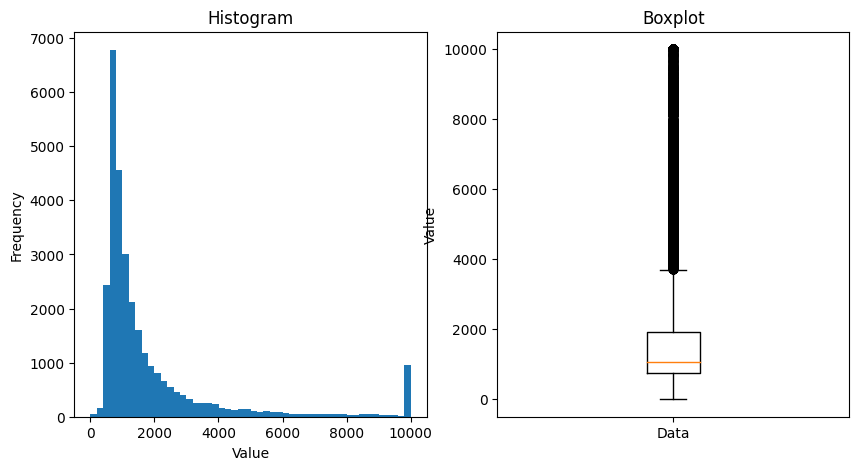

In [31]:
hist_and_box(n_occs_found_t)

In [26]:
(n_occs_found_t >= 10000).float().sum()

tensor(925.)

In [29]:
(n_occs_found_t >= 2000).float().sum()

tensor(7175.)

In [ ]:
negatives_occsL = load_pkl('/content/drive/MyDrive/thesis/derived_data/probing/bigrams_322k_occs_negatvies.pkl')

In [20]:
save_pkl(precise_occsL, '/content/drive/MyDrive/thesis/derived_data/probing/occurence_dicts/bigrams_322k_occs_precises_2k_bigrams_considered.pkl')

# Build occurence dicts

In [41]:
dope_bigram_ids = []
dope_occ_dicts = []

In [42]:
for bigram_id in tqdm(range(bigrams_considered)):
  bigram = tuple(bigrams[bigram_id].tolist())
  filtered_negatives_a = [pos for (pos, before, after) in negatives_occsL[bigram[0]] if after != bigram]

  thres = 2000
  if len(filtered_negatives_a) > thres:
    filtered_negatives_a = filtered_negatives_a[:thres]
  filtered_negatives_b = [pos for (pos, before, after) in negatives_occsL[bigram[1]] if before != bigram]
  if len(filtered_negatives_b) > thres:
    filtered_negatives_b = filtered_negatives_b[:thres]

  good_criterion = len(precise_occsL[bigram]) >= 1000 and len(filtered_negatives_b) >= thres and len(filtered_negatives_a) >= thres

  if good_criterion:
    dope_bigram_ids.append(bigram_id)
    occ_combi = {
      bigram: precise_occsL[bigram][:1000],
      (bigram[0], None): filtered_negatives_a,
      (None, bigram[1]): filtered_negatives_b
    }
    dope_occ_dicts.append((bigram_id, occ_combi))

100%|██████████| 30000/30000 [04:10<00:00, 119.88it/s]


In [44]:
len(dope_bigram_ids)

14557

In [45]:
with open('/content/drive/MyDrive/thesis/derived_data/probing/occurence_dicts/bigrams_322k_dope_occ_dicts_14k.pkl', 'wb') as f:
    pickle.dump(dope_occ_dicts, f)

# Occurence search

In [ ]:
from itertools import combinations
def generate_wildcards(trigram):
    # This function generates all possible wildcards for a given trigram
    n = len(trigram)
    wildcards = []
    for r in range(1, n+1):
        # Generate combinations of r elements
        for indices in combinations(range(n), r):
            wildcard = [None]*n
            for index in indices:
                wildcard[index] = trigram[index]
            wildcards.append(tuple(wildcard))
    return wildcards

def get_occurences_combi3(seqs_tensor, trigram, min_j=20, wildcard_list=None):
    # Get the length of trigram
    n = len(trigram)

    # Generate all possible wildcards for the trigram
    if wildcard_list is None:
      wildcard_list = generate_wildcards(trigram)

    # Sort wildcards by number of non-None elements (i.e., number of specified elements in the wildcard)
    wildcard_list.sort(key=lambda wildcard: wildcard.count(None))

    # Prepare an empty dictionary for storing the occurrences
    occurences = {wildcard: [] for wildcard in wildcard_list}
    occurences[trigram] = []

    # Now iterate over the seqs_tensor
    for i in tqdm(range(seqs_tensor.shape[0])):
        for j in range(min_j, 596): #seqs_tensor.shape[1] - n + 1):
            # Extract trigram from seqs_tensor
            seq_trigram = tuple(seqs_tensor[i, j:j+n].tolist())

            if seq_trigram == trigram:
                # If there's an exact match, append the location to the corresponding list in occurences
                occurences[trigram].append((i, j))
            else:
                # Compare this trigram with all possible wildcards, in increasing order of number of wildcards
                for wildcard in wildcard_list[1:]:
                    if all(w is None or w == n for w, n in zip(wildcard, seq_trigram)):
                        # If there's a match, append the location to the corresponding list in occurences and break the loop
                        if len(occurences[wildcard]) < 10000:
                          occurences[wildcard].append((i, j))
                        break

    return occurences

(187, 38)

In [ ]:
tokenizer.decode(bigram)

'\nE'

In [ ]:
def occ_to_seq(occ, before=20, after=5, decode=False):
  occ_seq, occ_pos = occ
  seq = T[occ_seq][occ_pos-before:occ_pos+after]
  if decode:
    return tokenizer.decode(seq)
  else: return seq

In [ ]:
len(dope_bigram_ids)

2463

In [ ]:
len(dope_occ_dicts)

2463

In [ ]:
dope_occ_dicts[0]

(0,
 {(187, 187): [(0, 25),
   (0, 47),
   (0, 84),
   (0, 110),
   (0, 127),
   (0, 159),
   (0, 207),
   (0, 234),
   (0, 300),
   (0, 322),
   (0, 360),
   (0, 378),
   (0, 401),
   (0, 430),
   (0, 437),
   (0, 497),
   (0, 523),
   (0, 559),
   (0, 579),
   (1, 44),
   (1, 79),
   (1, 123),
   (1, 169),
   (1, 182),
   (1, 235),
   (1, 246),
   (1, 346),
   (1, 386),
   (1, 410),
   (1, 463),
   (1, 497),
   (1, 506),
   (1, 549),
   (2, 24),
   (2, 183),
   (3, 178),
   (3, 223),
   (3, 252),
   (3, 417),
   (4, 72),
   (4, 100),
   (4, 158),
   (4, 252),
   (4, 339),
   (4, 449),
   (4, 470),
   (4, 494),
   (4, 581),
   (6, 36),
   (6, 56),
   (6, 86),
   (6, 117),
   (6, 148),
   (6, 200),
   (6, 228),
   (6, 284),
   (6, 347),
   (6, 394),
   (6, 455),
   (6, 489),
   (6, 543),
   (7, 28),
   (7, 60),
   (7, 74),
   (7, 81),
   (7, 104),
   (7, 112),
   (7, 119),
   (7, 125),
   (7, 133),
   (7, 140),
   (7, 146),
   (7, 151),
   (7, 158),
   (7, 163),
   (7, 167),
   (7, 171

10000
9981
4000


10000
8254
4000


In [ ]:
occ_to_seq(filtered_negatives_a[30], decode=True)

' course to win a total of 70 seats in total, giving them a majority in the new parliament.\n\nCitizens ('

In [ ]:
occ_combi = {
    bigram: precise_occs[bigram],
    (bigram[0], None): filtered_negatives_a,
    (None, bigram[1]): filtered_negatives_b
}

In [ ]:
for key, val in occ_combi.items():
  print(key, len(val))

(187, 1276) 1543
(187, None) 29862
(None, 1276) 326


In [ ]:
import pickle
import sys

In [ ]:
pickled_dict_size / (1024 ** 2)

92.97665309906006

NameError: ignored

In [ ]:
import random
def generate_tuples(a, b, c, d, n):
    result = []
    for _ in range(n):
        e = random.randint(a, b)
        f = random.randint(c, d)
        result.append((e, f))
    return result

In [ ]:
occ_combi[(None,None)] = generate_tuples(0,10000,20,596,6760)

In [ ]:
wildcard_keys = [(2675, 3988), (2675, None), (None, 3988)]
combi_cache_dict = {}
hooks_cached = ['blocks.1.hook_resid_pre',
                'blocks.1.hook_mlp_out',
                'blocks.2.hook_resid_pre',
                'blocks.2.hook_mlp_out',
                'blocks.3.hook_resid_pre',
                'blocks.3.hook_mlp_out']
for hook in hooks_cached:
  combi_cache_dict[hook] = {}
  for key in wildcard_keys:
    combi_cache_dict[hook][key] = []
combi_cache_dict

{'blocks.1.hook_resid_pre': {(2675, 3988): [],
  (2675, None): [],
  (None, 3988): []},
 'blocks.1.hook_mlp_out': {(2675, 3988): [],
  (2675, None): [],
  (None, 3988): []},
 'blocks.2.hook_resid_pre': {(2675, 3988): [],
  (2675, None): [],
  (None, 3988): []},
 'blocks.2.hook_mlp_out': {(2675, 3988): [],
  (2675, None): [],
  (None, 3988): []},
 'blocks.3.hook_resid_pre': {(2675, 3988): [],
  (2675, None): [],
  (None, 3988): []},
 'blocks.3.hook_mlp_out': {(2675, 3988): [],
  (2675, None): [],
  (None, 3988): []}}

In [ ]:
occ_to_seq(occ_combi[((None, 2675))][0], before=20, after=2, decode=True)

' Party\n\nThe Hungarian Socialist Party (), known mostly by its acronym MSZP, is a social'

In [ ]:
def hook_fc_key(value, hook, key):
  cached_tensor = value[0,-1]
  combi_cache_dict[hook.name][key].append(cached_tensor)
  return value

for key in wildcard_keys:
  print('KEY', key)

  def hook_fc_keyed(value, hook):
    return hook_fc_key(value, hook, key)

  fwd_hooks = [(hook_name, hook_fc_keyed) for hook_name in hooks_cached]
  print(fwd_hooks)

  for occ in tqdm(occ_combi[key]):
    occ_input = occ_to_seq(occ, before=20, after=3)
    model.run_with_hooks(
      occ_input,
      stop_at_layer=4,
      prepend_bos=False,
      return_type="loss",
      fwd_hooks=fwd_hooks
    )

KEY (2675, 3988)
[('blocks.1.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc3a0>), ('blocks.1.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc3a0>), ('blocks.2.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc3a0>), ('blocks.2.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc3a0>), ('blocks.3.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc3a0>), ('blocks.3.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc3a0>)]


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


KEY (2675, None)
[('blocks.1.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc550>), ('blocks.1.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc550>), ('blocks.2.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc550>), ('blocks.2.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc550>), ('blocks.3.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc550>), ('blocks.3.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc550>)]


100%|██████████| 662/662 [00:06<00:00, 100.74it/s]


KEY (None, 3988)
[('blocks.1.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc9d0>), ('blocks.1.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc9d0>), ('blocks.2.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc9d0>), ('blocks.2.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc9d0>), ('blocks.3.hook_resid_pre', <function hook_fc_keyed at 0x7fef26fcc9d0>), ('blocks.3.hook_mlp_out', <function hook_fc_keyed at 0x7fef26fcc9d0>)]


100%|██████████| 439/439 [00:04<00:00, 98.00it/s]


In [ ]:
combi_cache_dict_t = {}
for key, combi_dict in combi_cache_dict.items():
  combi_cache_dict_t[key] = {}
  for combi_key, combi_val in combi_dict.items():
    if len(combi_val) > 0:
      combi_cache_dict_t[key][combi_key] = torch.stack(combi_val)

In [ ]:
combi_cache_dict['blocks.1.hook_resid_pre'][(2675, 3988)]

[tensor([-6.3215e-03, -1.9206e-01, -3.3597e-02, -8.5328e-03,  2.4358e-02,
         -2.1316e-02,  1.9010e-01,  1.7395e-01,  8.1389e-02, -8.4765e-03,
         -2.5353e-01,  8.1155e-02,  1.7076e-01, -6.3796e-02,  5.4117e-02,
          1.7319e-01,  1.6231e-01, -7.3500e-01,  5.1085e-02, -2.7886e-01,
         -5.3912e-02, -1.5206e-01,  2.4291e-01, -2.6765e-01, -5.4648e-02,
         -7.5291e-02, -1.2016e-01, -1.8293e-01, -6.7232e-02, -3.7344e-02,
          6.8585e-02, -1.6913e-02,  1.5516e-01,  2.3764e-01,  9.1237e-03,
         -6.7702e-02, -2.4369e-01, -5.3373e-02,  1.1546e-01, -2.8980e-01,
         -1.4244e-01, -8.2711e-02, -1.2608e-01, -5.6641e-02, -1.5248e-01,
         -1.4655e-01, -1.0705e-01, -3.8463e-01, -1.2273e-01,  1.4846e-01,
          1.0133e-01, -1.8464e-01, -3.8585e-01,  2.7706e-01,  2.4232e-01,
         -1.6076e-01, -3.2187e-01, -9.4927e-02, -4.7356e-02, -1.4804e-01,
          1.0693e-01,  1.4983e-01,  3.1690e-01, -4.6663e-02, -3.4747e-01,
         -5.7854e-03,  1.4764e-01, -1.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn

def get_probe_dset(P_t, N_t, normalize=False, do_pca=False, do_probe=True):
  if normalize:
    P_t = F.normalize(P_t, dim=1)
    N_t = F.normalize(N_t, dim=1)
  X_pos = P_t.cpu().numpy()
  X_neg = N_t.cpu().numpy()
  y_pos = np.ones(X_pos.shape[0])
  y_neg = np.zeros(X_neg.shape[0])
  X = np.concatenate((X_pos, X_neg), axis=0)
  y = np.concatenate((y_pos, y_neg), axis=0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
probe_hook = 'blocks.2.hook_resid_pre'
probe_dset = get_probe_dset(combi_cache_dict_t[probe_hook][(2675, 3988)],
                            combi_cache_dict_t[probe_hook][(None, 3988)])

In [ ]:
def do_pca(probe_dset):
  X_train, X_test, y_train, y_test = probe_dset
  pca = PCA(n_components=2).fit(X_train)
  X_train_pca = pca.transform(X_train)
  plt.scatter(X_train_pca[:,0], X_train_pca[:,1],c=y_train)
  plt.title('Train')
  plt.show()
  X_test_pca = pca.transform(X_test)
  plt.scatter(X_test_pca[:,0], X_test_pca[:,1],c=y_test)
  plt.title('Test')
  plt.show()
  return pca

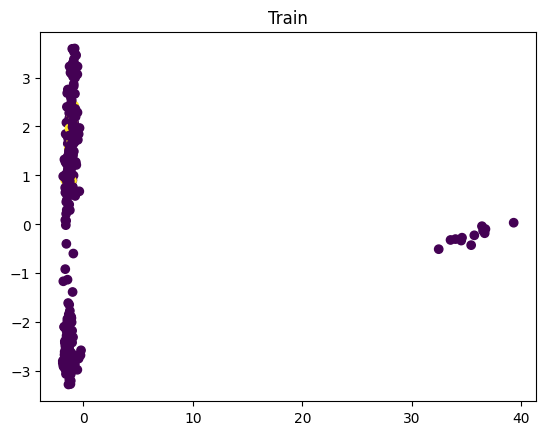

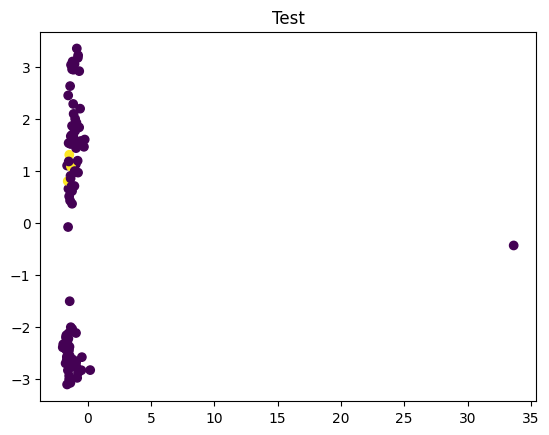

In [ ]:
pca_obj = do_pca(probe_dset)

In [ ]:
def do_probe(probe_dset, pca_obj):
  X_train, X_test, y_train, y_test = probe_dset
  lr = LogisticRegression(max_iter=1000)  # You might need to increase max_iter for convergence
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_test)
  y_prob = lr.predict_proba(X_test)[:, 1]

  if pca_obj is not None:
    X_test_pca = pca_obj.transform(X_test)
    plt.scatter(X_test_pca[:,0], X_test_pca[:,1],c=y_pred)
    plt.title('Probe on test')
    plt.show()

  # Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: ", accuracy)

  # F1 score
  f1 = f1_score(y_test, y_pred)
  print("F1 Score: ", f1)

  # Sensitivity aka Recall
  sensitivity = recall_score(y_test, y_pred)
  print("Sensitivity: ", sensitivity)

  # Precision
  precision = precision_score(y_test, y_pred)
  print("Precision: ", precision)

  # Specificity
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  specificity = tn / (tn+fp)
  print("Specificity: ", specificity)

  # Compute confusion matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)

  # Create a figure and an axis
  fig, ax = plt.subplots()

  # Create a heatmap
  sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

  # Set labels and title
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

  # Set x-axis and y-axis labels
  ax.xaxis.set_ticklabels(['Negative', 'Positive'])
  ax.yaxis.set_ticklabels(['Negative', 'Positive'])

  # Show the plot
  plt.show()
  return lr

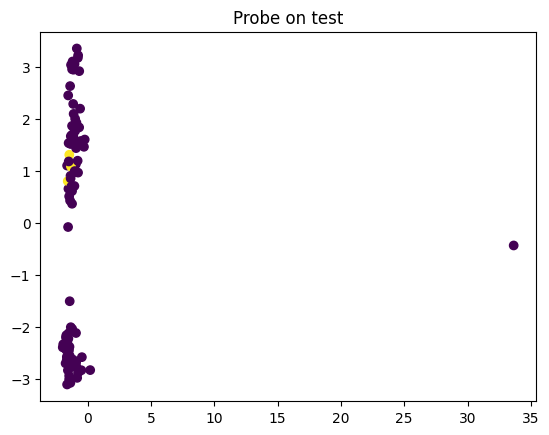

Accuracy:  1.0
F1 Score:  1.0
Sensitivity:  1.0
Precision:  1.0
Specificity:  1.0


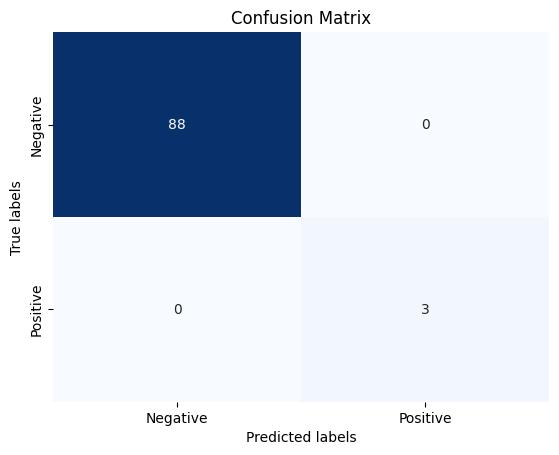

In [ ]:
clf = do_probe(probe_dset, pca_obj)